
# ResNet-50 Image Classification

## Introduction
This exercise implements the ResNet-50 image classification, a classic case in the deep learning field. The entire process is as follows: 
- Process the required dataset. (The flower image dataset is used in this example.)
- Define a network. You need to set up a ResNet-50 model structure.
- Define a loss function and an optimizer.
- Load the dataset and perform training. After the training is complete, use the test set for validation.

## Preparations
Before you start, check whether MindSpore has been correctly installed. You are advised to install MindSpore on your computer by referring to the [MindSpore official website](https://www.mindspore.cn/install/en). In addition, you should have basic mathematical knowledge, including knowledge of Python coding basics, probability, and matrices.

**Recommended environment:**
- Version: MindSpore 1.7
- Programming language: Python 3.7

##  Detailed Design and Implementation

### Data Preparation
The flower image dataset used in this example is an open-source dataset containing five flower types:
- Daisies (633 images)
- Dandelions (898 images)
- Roses (641 images)
- Sunflowers (699 images)
- Tulips (799 images)

The 3670 photos, which are about 230 MB in total, are stored in five folders. To facilitate the model test after deployment, the dataset is divided into `flower_photos_train` and `flower_photos_test`.

The directory structure is as follows:
flower_photos_train<br>
├── daisy<br>
├── dandelion<br>
├── roses<BR>
├── sunflowers<br>
├── tulips<br>
└── LICENSE.txt<br>

flower_photos_test<br>
├── daisy<br>
├── dandelion<br>
├── roses<BR>
├── sunflowers<br>
├── tulips<br>
└── LICENSE.txt<br>

Obtain the datasets from the following links: <br>https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deeplearning/flower_photos_train.zip <br>https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos_test.zip

### Procedure
#### **Import the Python Library and Module and Configure Running Information**


Import the required Python library

. For details about the MindSpore modules, see the [MindSpore API page](https://www.mindspore.cn/docs/en/master/api_python/mindspore.html). You can use `context.set_context` to configure the information required for running, such as the running mode, backend information, and hardware information

. Import the `context` module and configure the required informatio



In [1]:
from easydict import EasyDict as edict  # Dictionary access, used to store hyperparameters
import os  # os module, used to process files and directories
import numpy as np  # Scientific computing library
import matplotlib.pyplot as plt  # Graphing library
import mindspore  # MindSpore library
import mindspore.dataset as ds  # Dataset processing module
import mindspore.dataset.vision as vision  # Image enhancement module
from mindspore import context  # Environment setting module
import mindspore.nn as nn  # Neural network module
from mindspore.train import Model  # Model build
from mindspore.nn.optim.momentum import Momentum  # Momentum optimizer
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor  # Model saving settings
from mindspore import Tensor  # Tensor
from mindspore.train.serialization import export  # Model export
from mindspore.train.loss_scale_manager import FixedLossScaleManager  # Loss value smoothing
from mindspore.train.serialization import load_checkpoint, load_param_into_net  # Model loading
import mindspore.ops as ops  # Common operators

# MindSpore execution mode and device setting
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

#### Step 2 Define parameter variables. 
The edict stores the parameter configurations required for model training and testing.

In [11]:
cfg = edict({
    'data_path': '../datasets/Flower_Photos/flower_photos_train',  # Path of the training dataset
    'test_path': '../datasets/Flower_Photos/flower_photos_test',  # Path of the test dataset
    'data_size': 3670,  # Number of images in the dataset
    'HEIGHT': 224,  # Image height
    'WIDTH': 224,  # Image width
    '_R_MEAN': 123.68,  # Average value of the red channel in CIFAR-10 dataset
    '_G_MEAN': 116.78,  # Average value of the green channel in CIFAR-10 dataset
    '_B_MEAN': 103.94,  # Average value of the blue channel in CIFAR-10 dataset
    '_R_STD': 1,  # Customized standard deviation for the red channel
    '_G_STD': 1,  # Customized standard deviation for the green channel
    '_B_STD': 1,  # Customized standard deviation for the blue channel
    '_RESIZE_SIDE_MIN': 256,  # Minimum resize value for image enhancement
    '_RESIZE_SIDE_MAX': 512,  # Maximum resize value for image enhancement
    'batch_size': 32,  # Number of images processed in each batch during training
    'num_class': 5,  # Number of classes in the dataset
    'epoch_size': 5,  # Number of epochs or training iterations
    'loss_scale_num': 1024,  # Scale factor for the loss value
    'prefix': 'resnet-ai',  # Prefix name for the model
    'directory': './model_resnet',  # Directory path where the model will be stored
    'save_checkpoint_steps': 10,  # Save checkpoint after every 10 steps
})

#### **Step 3: Read and Process Data**

Datasets are crucial for training. A good dataset can effectively improve training accuracy and efficiency. Generally, before loading a dataset, you need to perform some operations on the dataset. Define a dataset and data operations. We define the `create_dataset` function to create a dataset. In this function, we define the data augmentation and processing operations to be performed:

- Read the dataset.
- Define parameters required for data augmentation and processing.
- Generate corresponding data augmentation operations according to the parameters.
- Use the `map` function to apply data operations to the dataset.
- Process the generated dataset.
- Display the processed data as an example.


Number of training datasets:  3616
Number of test datasets:  52
Number of channels/Image length/width:  (3, 224, 224)
Label style of an image:  4


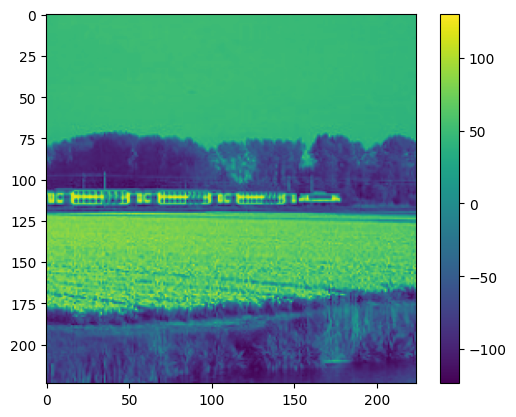

In [12]:
# Data processing
def read_data(path, config, usage="train"):
    # Read the source dataset of images from a directory.
    dataset = ds.ImageFolderDataset(
        path, 
        class_indexing={'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
    )

    # Define map operations
    # Operator for image decoding
    decode_op = vision.Decode()
    # Operator for image normalization
    normalize_op = vision.Normalize(mean=[cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN], 
                                    std=[cfg._R_STD, cfg._G_STD, cfg._B_STD])
    # Operator for image resizing
    resize_op = vision.Resize(cfg._RESIZE_SIDE_MIN)
    # Operator for image cropping
    center_crop_op = vision.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
    # Operator for image random horizontal flipping
    horizontal_flip_op = vision.RandomHorizontalFlip()
    # Operator for image channel quantity conversion
    channelswap_op = vision.HWC2CHW()
    # Operator for random image cropping, decoding, encoding, and resizing
    random_crop_decode_resize_op = vision.RandomCropDecodeResize((cfg.HEIGHT, cfg.WIDTH), 
                                                                 (0.5, 1.0), (1.0, 1.0), max_attempts=100)

    # Preprocess the training set.
    if usage == 'train':
        dataset = dataset.map(input_columns="image", operations=random_crop_decode_resize_op)
        dataset = dataset.map(input_columns="image", operations=horizontal_flip_op)
    # Preprocess the test set.
    else:
        dataset = dataset.map(input_columns="image", operations=decode_op)
        dataset = dataset.map(input_columns="image", operations=resize_op)
        dataset = dataset.map(input_columns="image", operations=center_crop_op)

    # Preprocess all datasets.
    dataset = dataset.map(input_columns="image", operations=normalize_op)
    dataset = dataset.map(input_columns="image", operations=channelswap_op)

    # Batch the training set.
    if usage == 'train':
        dataset = dataset.shuffle(buffer_size=10000)  # 10000 as in ImageNet train script
        dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
    # Batch the test set.
    else:
        dataset = dataset.batch(1, drop_remainder=True)

    # Data augmentation
    dataset = dataset.repeat(1)
    dataset.map_model = 4

    return dataset

# Display the numbers of training sets and test sets.
de_train = read_data(cfg.data_path, cfg, usage="train")
de_test = read_data(cfg.test_path, cfg, usage="test")

print('Number of training datasets: ', de_train.get_dataset_size() * cfg.batch_size)  # get_dataset_size() obtains the batch processing size.
print('Number of test datasets: ', de_test.get_dataset_size())

# Display the sample graph of the training set.
data_next = de_train.create_dict_iterator(output_numpy=True).__next__()
print('Number of channels/Image length/width: ', data_next['image'][0, ...].shape)
print('Label style of an image: ', data_next['label'][0])  # Total 5 label classes which are represented by numbers from 0 to 4.

plt.figure()
plt.imshow(data_next['image'][0, 0, ...])
plt.colorbar()
plt.grid(False)
plt.show()


#### Step 4: Build and Train the Model

- **Define the Model:**
  - **Residual Blocks:**
    - Residual blocks use the output of the first several layers as the input of the last several layers, skipping the intermediate layers. This design helps to address issues related to impaired learning efficiency and accuracy that occur as the number of network layers increases. The key idea is to add the output of the skipped layers to the final layers' output, which can be expressed as follows:
      ![Local Image](ResNet-building-block.png)

      - If the dimensions are the same: 
        \[
        y = F(x, W_i) + x
        \]
        Where \( F = W_2 \sigma(W_1, x) \).
      - If the dimensions are different:
        \[
        y = F(x, W_i) + W_s x
        \]
      - For more details, refer to the [Residual Networks paper](https://arxiv.org/pdf/1512.03385.pdf).

  - **Bottleneck Module:**
    - The bottleneck module utilizes a 1x1 convolutional layer to either reduce or expand the feature map dimensions. This ensures that the number of filters in the 3x3 convolutional layer is not affected by the input size of the upper layer, and the output of the 3x3 convolutional layer does not affect the lower-layer module<br>
      ![Local Image](deeper-residual-function.png)<br>
      [Residual Networks paper](https://arxiv.org/pdf/1512.03385.pdf)
      **ResNet-50 Model**

ResNet-50 has two basic blocks: convolutional block and identity block. The input and output dimensions of the convolutional block are different and cannot be connected in series. The convolutional block is used to change the network dimensions. The identity block has the same input and output dimensions, which can be connected in series to deepen the network.<br>
![Local Image](ResNet-architecture.png)<br>
       [Residual Networks paper](https://arxiv.org/pdf/1512.03385.pdf)
.

In [15]:
"""
ResNet.
"""

# Define the weight initialization function.
def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)

# Define the 3x3 convolution layer functions.
def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=0, 
                     pad_mode='same', weight_init=weight)

# Define the 1x1 convolution layer functions.
def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, padding=0, 
                     pad_mode='same', weight_init=weight)

# Define the 7x7 convolution layer functions.
def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel, kernel_size=7, stride=stride, padding=0, 
                     pad_mode='same', weight_init=weight)

# Define the Batch Norm layer functions.
def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9, gamma_init=1, beta_init=0, 
                          moving_mean_init=0, moving_var_init=1)

# Define the Batch Norm functions at the last layer.
def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9, gamma_init=0, beta_init=0, 
                          moving_mean_init=0, moving_var_init=1)

# Define the functions of the fully-connected layers.
def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)

# Construct a residual module.
class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.
    
    Args:
        in_channel (int): Input channel.
        out_channel (int): Output channel.
        stride (int): Stride size for the first convolutional layer. Default: 1.
    
    Returns:
        Tensor, output tensor.
    
    Examples:
        >>> ResidualBlock(3, 256, stride=2)
    """
    expansion = 4   # In conv2_x--conv5_x, the number of convolution kernels at the first \n two layers is one fourth of the number of convolution kernels at the third layer (an output channel).

    def __init__(self, in_channel, out_channel, stride=1):
        super(ResidualBlock, self).__init__()

        # The number of convolution kernels at the first two layers is equal to a quarter of the number of convolution kernels at the output channels.
        channel = out_channel // self.expansion

        # Layer 1 convolution
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)

        # Layer 2 convolution
        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)

        # Layer 3 convolution
        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)

        # ReLU activation layer
        self.relu = nn.ReLU()
        self.down_sample = False

        # Downsampling if required
        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
            self.down_sample_layer = nn.SequentialCell([
                _conv1x1(in_channel, out_channel, stride),  # 1x1 convolution
                _bn(out_channel)  # Batch Norm
            ])

        # Addition operator
        self.add = ops.Add()

    # Construct a residual block.
    def construct(self, x):
        identity = x

        # Layer 1 convolution 1x1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Layer 2 convolution 3x3
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # Layer 3 convolution 1x1
        out = self.conv3(out)
        out = self.bn3(out)

        # Change the network dimension if downsampling
        if self.down_sample:
            identity = self.down_sample_layer(identity)

        # Add the residual
        out = self.add(out, identity)

        # ReLU activation
        out = self.relu(out)

        return out

# Construct a residual network.
class ResNet(nn.Cell):
    """
    ResNet architecture.
    
    Args:
        block (Cell): Block for network.
        layer_nums (list): Numbers of block in different layers.
        in_channels (list): Input channel in each layer.
        out_channels (list): Output channel in each layer.
        strides (list): Stride size in each layer.
        num_classes (int): The number of classes that the training images belong to.
    
    Returns:
        Tensor, output tensor.
    
    Examples:
        >>> ResNet(ResidualBlock,
        >>>        [3, 4, 6, 3],
        >>>        [64, 256, 512, 1024],
        >>>        [256, 512, 1024, 2048],
        >>>        [1, 2, 2, 2],
        >>>        10)
    """

    def __init__(self, block, layer_nums, in_channels, out_channels, strides, num_classes):
        super(ResNet, self).__init__()
        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")

        # Layer 1 convolution; 7x7, input channels: 3; output channels: 64; stride: 2
        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = ops.ReLU()

        # 3x3 pooling layer; stride: 2
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        # conv2_x residual block
        self.layer1 = self._make_layer(block, layer_nums[0], in_channel=in_channels[0], 
                                       out_channel=out_channels[0], stride=strides[0])

        # conv3_x residual block
        self.layer2 = self._make_layer(block, layer_nums[1], in_channel=in_channels[1], 
                                       out_channel=out_channels[1], stride=strides[1])

        # conv4_x residual block
        self.layer3 = self._make_layer(block, layer_nums[2], in_channel=in_channels[2], 
                                       out_channel=out_channels[2], stride=strides[2])

        # conv5_x residual block
        self.layer4 = self._make_layer(block, layer_nums[3], in_channel=in_channels[3], 
                                       out_channel=out_channels[3], stride=strides[3])

        # Mean operator
        self.mean = ops.ReduceMean(keep_dims=True)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Output layer
        self.end_point = _fc(out_channels[3], num_classes)

    # Create a stage network for ResNet
    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        """
        Make stage network of ResNet.
        
        Args:
            block (Cell): Resnet block.
            layer_num (int): Layer number.
            in_channel (int): Input channel.
            out_channel (int): Output channel.
            stride (int): Stride size for the first convolutional layer.
        
        Returns:
            SequentialCell, the output layer.
        
        Examples:
            >>> _make_layer(ResidualBlock, 3, 128, 256, 2)
        """
        layers = []
        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)
        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)
        return nn.SequentialCell(layers)

    # Build a ResNet network.
    def construct(self, x):
        x = self.conv1(x)  # Layer 1 convolution: 7x7; stride: 2
        x = self.bn1(x)  # Batch Norm of layer 1
        x = self.relu(x)  # ReLU activation layer
        c1 = self.maxpool(x)  # Max pooling: 3x3; stride: 2
        c2 = self.layer1(c1)  # conv2_x residual block
        c3 = self.layer2(c2)  # conv3_x residual block
        c4 = self.layer3(c3)  # conv4_x residual block
        c5 = self.layer4(c4)  # conv5_x residual block
        out = self.mean(c5, (2, 3))  # Mean pooling layer
        out = self.flatten(out)  # Flatten layer
        out = self.end_point(out)  # Output layer

        return out

# Build a ResNet-50 network.
def resnet50(class_num=5):
    """
    Get ResNet50 neural network.

    Args:
        class_num (int): Number of output classes.

    Returns:
        Cell: Cell instance of ResNet50 neural network.

    Examples:
        >>> net = resnet50(10)
    """
    return ResNet(
        ResidualBlock,          # Residual block type
        [3, 4, 6, 3],           # Number of residual blocks at each stage
        [64, 256, 512, 1024],   # Number of input channels at each stage
        [256, 512, 1024, 2048], # Number of output channels at each stage
        [1, 2, 2, 2],           # Stride at each stage
        class_num               # Number of output classes
    )



**Start Training**

After preprocessing data and defining the network, loss function, and optimizer, start model training. Model training involves two main iterations:

Multi-Epoch Iteration: Iterating over the entire dataset multiple times.
Single-Step Iteration: Iterating over the dataset in batches. In each batch:
Extract Data: Retrieve a batch of data from the dataset.
Forward Pass: Input the data into the network to compute the loss.
Backward Pass: Calculate and update the gradients of the training parameters using an optimizer.
1. Download a Pre-trained Model
Create Directory: Create the model_resnet directory.
Download Model: Download the pre-trained model file from the following link:<br>
    [https://download.mindspore.cn/models/r1.7/resnet50_ascend_v170_imagenet2012_official_c]<br>
Save File: Save the downloaded file to the model_resnet directory.
3. Load the Pre-trained Model
Read File: Use the load_checkpoint() API to read the pre-trained model file.
Obtain Parameters: The model parameters will be loaded in dictionary format.
4. Modify Pre-trained Model Parameters
Update Last Layer: Modify the parameters of the last layer to match the number of output classes for your specific task. The pre-trained model is designed to classify 1001 types of objects. For your task, which involves classifying five types of flowers, update the parameters of the last fully connected layer accordingly.

In [ ]:
# Construct a ResNet-50 network with 5 output classes (for flower classification).
net = resnet50(class_num=cfg.num_class)

# Read the parameters of the pre-trained model.
param_dict = load_checkpoint("model_resnet/resnet50_ascend_v1100_imagenet2012_official_cv_top1acc76.97_top5acc93.44.ckpt")

# Display the read model parameters.
print(param_dict)

param_dict["end_point.weight"] = mindspore.Parameter(
    Tensor(param_dict["end_point.weight"][:5, :], mindspore.float32), name="variable"
)
param_dict["end_point.bias"] = mindspore.Parameter(
    Tensor(param_dict["end_point.bias"][:5,], mindspore.float32), name="variable"
)

# Set the Softmax cross-entropy loss function
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

# Set the learning rate
train_step_size = de_train.get_dataset_size()
lr = nn.cosine_decay_lr(
    min_lr=0.0001,
    max_lr=0.001,
    total_step=train_step_size * cfg.epoch_size,
    step_per_epoch=train_step_size,
    decay_epoch=cfg.epoch_size
)

# Set the momentum optimizer
opt = Momentum(
    net.trainable_params(),
    lr,
    momentum=0.9,
    weight_decay=1e-4,
    loss_scale=cfg.loss_scale_num
)

# Smooth the loss value to handle gradient scaling
loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)

# Build the model
model = Model(
    net,
    loss_fn=loss,
    optimizer=opt,
    loss_scale_manager=loss_scale,
    metrics={'acc'}
)

# Loss value monitoring
loss_cb = LossMonitor(per_print_times=train_step_size)

# Model saving parameters
ckpt_config = CheckpointConfig(
    save_checkpoint_steps=cfg.save_checkpoint_steps,
    keep_checkpoint_max=1
)

# Save the model
ckpoint_cb = ModelCheckpoint(
    prefix=cfg.prefix,
    directory=cfg.directory,
    config=ckpt_config
)

print("============== Starting Training ==============")

# Train the model
model.train(
    cfg.epoch_size,
    de_train,
    callbacks=[loss_cb, ckpoint_cb],
    dataset_sink_mode=True
)

# The training takes approximately 15 to 20 minutes.

# Evaluate the model on the test set
metric = model.eval(de_test)
print(metric)

{'conv1.weight': Parameter (name=conv1.weight, shape=(64, 3, 7, 7), dtype=Float32, requires_grad=True), 'bn1.gamma': Parameter (name=bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'bn1.beta': Parameter (name=bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv1.weight': Parameter (name=layer1.0.conv1.weight, shape=(64, 64, 1, 1), dtype=Float32, requires_grad=True), 'layer1.0.bn1.gamma': Parameter (name=layer1.0.bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn1.beta': Parameter (name=layer1.0.bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv2.weight': Parameter (name=layer1.0.conv2.weight, shape=(64, 64, 3, 3), dtype=Float32, requires_grad=True), 'layer1.0.bn2.gamma': Parameter (name=layer1.0.bn2.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn2.beta': Parameter (name=layer1.0.bn2.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv3.weight': Parameter (name=layer1.0.co